# Loco Mosquito

The program to extract, clean and prepare the IR spectra from mosquitoes. 



### Changelog

    1.0 - Original program.
    1.1 - Adapted for new file names with country code.
        - Added code to avoid processing files with wrong names.
        - Solved bug in the code that plots a spectrum and the selected wavenumbers.
    2.0 - Added an algorithm to being able to read files with names without country code.
        - It plots a bar and wiskers graph with the results of the mosquitoes.
        - Added an algorithm to detect when the selected wavenumbers are out of the measured ranges.
    3.0 - Supports .mzz files.
    3.1 - Supoorts the new (after Ifakara meeting) and the old naming systems.
        - New wrong-mosquito-stubborn-namer-proof system.
        - Included all the modifications from Loco Mosquito "Mwanga edition", including the posibility of using two wavenumbers to select ranges instead individual peaks.
        - Corrects the selection of peaks in case they have wavenumbers that are not in the spectra range.
    3.2 - Ready for the analysis of a large number of files in diferent folders.
        - Makes a list with the files with wrong names.
    3.3 - Deals with errors in the dates of the mosquitoes.
    4.0 - Ignores the name of the ``*.tmp`` file inside the ``*.mzz`` file.
        - Discriminates between the rearing conditions of the mosquitoes.
        - Includes an algorithm to select what mosquitoes you want to use in the final matrix.
    4.1 - Added in tqdm to make use of a progress bar during the long phase of loading in spectra.
        - Modified reading the spectra to include the country. Further changes throughout shift the spectra position in the matricies to accomodate the country matrix location.
        - Added in a sub total in the mosquito number summary display.




### Useful packages

First of all, we are going to load all the packages that we will need for our program

In [1]:
import numpy as np #we will use numpy to process the data
import os 
import time
import csv
import matplotlib.pyplot as plt
import zipfile
import zlib
from tqdm import tqdm

### Loading the spectra

All spectra to be processed must be stored in a text file or a ``*.mzz file``, in the same folder (it doesn't matter if they are organised in subfolders) and with a descriptive name of their status, which must follow the following format:

```
kk-C-xxD-yy-zz-mm-888888-555555-33.dpt (or *.mzz)
```

where:

* **kk**: Species code
    * **AA**: _Anopheles arabiensis_
    * **AG**: _Anopheles gambiae_
    * **AC**: _Anopheles coluzzi_
* **C**: Country code
    * **B**: Burkina Faso
    * **T**: Tanzania
    * **S**: Scotland
* **xx**: Age of the mosquito in days
* **yy**: Status of the mosquito
    * **BF**: Blood fed
    * **SF**: Sugar fed
    * **UF**: Unfed
    * **GR**: Gravid
* **zz**: Insecticide resistance
    * **RE**: Resistant
    * **SU**: Susceptible
    * **UN**: Unknown
* **mm**: Rear conditions
    * **TL**: Time course lab
    * **TF**: Time course field
    * **VF**: Validation Field
* **888888**: Date the mosquito was measured
* **555555**: Date the mosquito was collected
* **33**: Mosquito number identifier (ignored during the processing)

Although it is also possible to read files with the old naming systems without country code, insecticide resistance or rear conditions:

```
kk-xxD-yy-888888-555555-zz.dpt (or *.mzz)
```

```
kk-C-xxD-yy-888888-555555-zz.dpt (or *.mzz)
```

```
kk-C-xxD-yy-zz-888888-555555-zz.dpt (or *.mzz)
```

Here is the algorithm to load the spectra, but first you must indicate the folder location. To do this, the easiest way to proceed is just going to a file in the folder where the spectra are, right-click on it, select properties, and, then, copy the text at the right of "Location:". Remember to add `\` at the end if you are using Windows or `/` if you are using an UNIX os

In [2]:
spectra_path = input("Please, indicate the folder location: ")

Please, indicate the folder location: /home/josh/Documents/Mosquito_Project/New_Data/Data/MIMIdata/


In [3]:
a = time.time()
# find all the .mzz and .dpt files in the folder (and its subfolders)
dptfiles = []
mzzfiles = []
for root, dirs, files in os.walk(spectra_path):
    for file in files:
        if file.endswith(".dpt"):
             dptfiles.append(os.path.join(root, file))
        elif file.endswith(".mzz"):
             mzzfiles.append(os.path.join(root, file))
#If there are *.mzz files, we will not consider the *.dpt files
if len(mzzfiles) > 0:
    spectra_names = mzzfiles
    mzzq = True
else:
    spectra_names = dptfiles
    mzzq = False
# we prepare the lists that are going to contain all the info collected
matrix = []
list_ages = []
list_status = []
list_species = []
list_rear = []
list_country = []
wrong_named = []
# Now we load the spectra in a matrix
for i in tqdm(spectra_names):
    # To obtain the info from the name of the file, first we split the name in the different sections:
    tmp = os.path.basename(i).split(".")[0].split(" ")[0].split("-")
    # The first part in all the naming systems is always the species
    j = 0
    species = tmp[j]
    # Species have to be named with two letters. If not we will not consider them:
    if len(species) != 2:
        wrong_named.append(i)
        continue # we don't add this spectrum to the matrix
    # if we have passed this test, we check if the specie is already seen
    if species in list_species:
        pass
    else:
        list_species.append(species)
    # And then we move to the country, then age
    j += 1
    # If there is the country code, add it
    if len(tmp[j]) <= 2:
        country = tmp[j]
        if country in list_country:
            pass
        else:
            list_country.append(country)
        j += 1
    # And because there is always somebody that forgets to add the 0 in the ages smaller than 10 days...
    if len(tmp[j]) == 2:
        age = '0' + tmp[j]
    else:
        age = tmp[j]
    age = age[:2]
    # Ages have to be named with three characteres. If not we will not consider them:
    if len(age) != 2:
        wrong_named.append(i)
        continue # we don't add this spectrum to the matrix
    if age in list_ages:
        pass
    else:
        list_ages.append(age)
    # The next part is the status of the mosquito
    j += 1
    status = tmp[j]
    # Status have to be named with two letters. If not we will not consider them:
    if len(status) != 2:
        wrong_named.append(i)
        continue # we don't add this spectrum to the matrix
    if status in list_status:
        pass
    else:
        list_status.append(status)
    # And finally the collection and measurement dates
    j += 1
    # Here we check if the insecticide resistance and rear condition is stated
    if len(tmp[j]) == 2:
        # if it doesn't start with V or T must be the insecticide resistance (and for the time being we dont care about it)
        if tmp[j][0] != "V" or tmp[j][0] != "T":
            j += 1
    # Now we check the rearing condition:
    rear = tmp[j]
    # Rearing conditions have to be named with two letters. If not we will not consider them:
    if len(rear) != 2:
        wrong_named.append(i)
        continue # we don't add this spectrum to the matrix
    # if we have passed this test, we check if the specie is already seen
    if rear in list_rear:
        pass
    else:
        list_rear.append(rear)
    # And then we move to the dates
    j += 1
    # Now we check that the dates are well written and if not we discard the file
    if len(tmp[j]) != 6:
        wrong_named.append(i)
        continue
    try:
        colday = time.mktime(time.strptime(tmp[j],"%y%m%d"))
    except:
        wrong_named.append(i)
        continue
    j += 1
    if len(tmp[j]) != 6:
        wrong_named.append(i)
        continue
    try:
        mesday = time.mktime(time.strptime(tmp[j],"%y%m%d"))
    except:
        wrong_named.append(i)
        continue
    stime = abs((mesday - colday) / (3600 * 24))
    # And finally the spectrum and its characteristics
    if mzzq == False:
        with open(i, 'rb') as tmp:
            avmi = (line.replace(b'\t',b',') for line in tmp)
            spectrum = np.genfromtxt(avmi, delimiter=',')
        start = spectrum[0,0]
        end = spectrum[-1,0]
        ls = len(spectrum)
        spectrum = np.transpose(spectrum)[1]    
    else:
        with zipfile.ZipFile(i) as myzip:
            tmpname = myzip.namelist()[0]
            with myzip.open(tmpname) as myfile:
                spectrum = np.genfromtxt(myfile, delimiter=',')
        start = spectrum[0]
        end = spectrum[1]
        ls = int(spectrum[2])
        spectrum = spectrum[3:]
    matrix.append([species,age,status,country,rear,stime,[start,end,ls],spectrum])
list_species = sorted(list_species)
list_ages = sorted(list_ages)
list_status = sorted(list_status)
list_country = sorted(list_country)
list_rear = sorted(list_rear)
b = time.time()
print("This last process has lasted " + str(round(b-a,3)) + " s. " + str(len(wrong_named)) + " files were not read because their name")

100%|██████████| 41151/41151 [03:01<00:00, 226.99it/s]

This last process has lasted 181.374 s. 0 files were not read because their name


If you want to check which are the files that the program could not read evaluate the next cell:

In [4]:
wrong_named

[]

The following code allows us to count the number of mosquitoes for each specie, age, and status. 

In [5]:
mos_acc = []
for j in range(len(list_rear)):
    mos_acc.append(np.zeros((len(list_species),len(list_status),len(list_ages)),dtype=int)) # We create an empty table for the 
    for i in range(len(matrix)):
        if matrix[i][4] == list_rear[j]:
            x = list_species.index(matrix[i][0])
            y = list_status.index(matrix[i][2])
            z = list_ages.index(matrix[i][1])
            mos_acc[j][x][y][z] += 1
            
mos_acc_2 = [np.zeros((3,3)) for i in range(3)]
for i in range(len(mos_acc)):
    for j in range(mos_acc[0].shape[0]):
        for k in range(mos_acc[0].shape[1]):
            mos_acc_2[i][j][k] = np.sum(mos_acc[i][j][k])

# We show it in a beautiful way
width = ((len(list_ages) + 2) * 5) - 2
print()
for j in range(len(list_rear)):
    if list_rear[j] == "TF":
        nare = "Time course Field:"
    elif list_rear[j] == "TL":
        nare = "Time course Lab:"
    else:
        nare = "Validation Field:"
    print(nare)
    for i in range(mos_acc[j].shape[0]):
        print(" " * (round(width/2) -2) + list_species[i])
        print("=" * width)
        print("    "+'   '.join(map(str, list_ages))+"  "+'Total') 
        print("-" * width)
        for k in range(mos_acc[j].shape[1]):
            print(list_status[k] + " " + "  ".join(["%3.0f" % dx for dx in mos_acc[j][i][k]]) + "   " + "".join("%3.0f" % mos_acc_2[j][i][k]))
        print()
        print(('Total '+list_species[i]+' : '+str(np.sum(mos_acc_2[j][i]))))
    print(" " * width + "Total: " + str(np.sum(mos_acc[j])))
    print()


Time course Field:
                                            AA
    01   02   03   04   05   06   07   08   09   10   11   12   13   14   15   16   17  Total
---------------------------------------------------------------------------------------------
BF   0    0   96  157  101    0    0    0   71   78   71    0    0    0  102  101  101   878
GR   0    0    0    0  102  102  101    0    0    0   98  101   91    0    0    0   82   677
SF  71   81   95  198  206  259  325  406  303  364  195  286  331  430  312  308  213   4383

Total AA : 5938.0
                                            AC
    01   02   03   04   05   06   07   08   09   10   11   12   13   14   15   16   17  Total
---------------------------------------------------------------------------------------------
BF   0    0    0    0    0    0    0    0    0    0   60   45   32   28   39   36   31   271
GR   0    0    0    0    0    0    0    0    0    0   33   32   35   30   43   40   49   262
SF   0    0    0    0    

## Detection of bad spectra

### Spectra with low intensity

If the mosquito was not well placed at the ATR's crystal, the intensity of the whole spectrum is small. Our experience says that we can use as reference the small plateau between 400 and 500 wavenumbers that the mosquito spectra usually have. Since, the spectrometer with ZnSe optics only can reach to 500 wavenumbers, it doesn matter if we extend this range to 600 cm<sup>-1</sup>. Then if the average of this reference is smaller than 0.11, the spectrum doesn't have enough quality to be scaled and, then, of course, employed.

In [6]:
# A list of the discarted spectra will be collected:
bad_spectra = []
for i in range(len(matrix)):
    # first we calculate the position of the points that comprise that section of the spectrum
    if matrix[i][6][1] < 600 and matrix[i][6][1] > 400:
        sta = int(round((((matrix[i][6][2] - 1) / (matrix[i][6][1] - matrix[i][6][0])) * (600 - matrix[i][6][0])) + 1)) - 1
        end = matrix[i][6][2]
    elif matrix[i][6][1] <= 400:
        sta = int(round((((matrix[i][6][2] - 1) / (matrix[i][6][1] - matrix[i][6][0])) * (600 - matrix[i][6][0])) + 1)) - 1
        end = int(round((((matrix[i][6][2] - 1) / (matrix[i][6][1] - matrix[i][6][0])) * (400 - matrix[i][6][0])) + 1)) - 1
    else:
        sta = 0 # if the spectrum doesn't reach 600 cm-1 we cannot prove if the spectrum has enough intensity
        raise Exception("The spectrum {} doesn't reach 600 cm-1".format(spectra_names[1]))
    # Now we check the intensity of the spectra in that region. If is not over 0.1 we discard the spectrum
    if np.average(matrix[i][7][sta:end]) < 0.11:
        bad_spectra.append("LI: " + spectra_names[i])
        matrix[i] = None
if (bad_spectra) == 1:
    print("1 spectrum has been discarded because its low intensity")
else:
    print(str(len(bad_spectra)) + " spectra have been discarded because their low intensity")

943 spectra have been discarded because their low intensity


### Spectra with atmospheric interferences

If the spectra were measured after the change of the beamspliter or after installing the ATR and the background was not correctly measured, the spectra will be with the interference of the water and CO<sub>2</sub> spectra. In the case of water vapour, its IR spectrum has three bands very noisy: one between 4000 and 3400 cm<sup>-1</sup>, other between 2200 and 1300 cm<sup>-1</sup> and the last one starts to appear below 800 cm<sup>-1</sup>. Because the second band appears exactly were the most interesting bands of the mosquitoes are, we are going to use the first band to detect the spectra contaminated by the water vapor and remove it from our data. In order to do that we check how smooth are the spectra between 3900 and 3500 cm<sup>-1</sup>, fitting that region to a polynomial. Only the spectra without noise will fit well.

In [7]:
bs = 0 # counter for the number of spectra discarderd

# Now we define a function to calculate the R-squared coefficient of the fitting of our data to a polynomial
def rs_pf(x, y, degree):
    coeffs = np.polyfit(x, y, degree)
    # r-squared
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results = ssreg / sstot

    return results

# Here take that the section of the data between 3900 and 3500 cm-1 and check if it fits well to a 5th degree polinomial
for i in range(len(matrix)):
    if matrix[i]: #to check if we have spectra
        # Now one would spect that the spectrum will reach 3900 so the program will not check it out.
        sta = int(round((((matrix[i][6][2] - 1) / (matrix[i][6][1] - matrix[i][6][0])) * (3900 - matrix[i][6][0])) + 1)) - 1
        end = int(round((((matrix[i][6][2] - 1) / (matrix[i][6][1] - matrix[i][6][0])) * (3500 - matrix[i][6][0])) + 1)) - 1
        # we take that data:
        yd = matrix[i][7][sta:end]
        xd = list(range(len(yd)))
        rs = rs_pf(xd,yd,5)
        # And now, if the fitting is bad, we discard the spectrum
        if rs < 0.99:
            bs +=1
            bad_spectra.append("AI: " + spectra_names[i])
            matrix[i] = None
if (bs) == 1:
    print("1 spectrum has been discarded because has atmospheric interferences")
else:
    print(str(bs) + " spectra have been discarded because have atmospheric interferences")   

4379 spectra have been discarded because have atmospheric interferences


### Spectra shifted by the anvil

Sometimes, when you are measuring a mosquito, the mosquito moves out of the ATR crystal and what you get is a plain spectrum without features (apart from CO<sub>2</sub> bands) but with high intensity. Sometimes these spectra pass the previous filters and it is necessary to remove them. To do it that we are going to do is to select the wavenumber with less signal from the mosquito (this wavenumber is usually 1900 cm<sup>-1</sup>) and look for outliers at that frequency.

In [8]:
bs = 0 # counter for the number of spectra discarderd 
# we calculate the fences of the data set based in a value we can choose (in statistics 1.5 times
# the interquartile range is the inner fence and 3 time is the outer fence)
l = 1.5
# We look for the point at 1900 cm-1 and add it to the list of intensities
li = []
for i in range(len(matrix)):
    if matrix[i]: #to check if we have spectra
        # Now one would spect that the spectrum will reach 3900 so the program will not check it out.
        sta = int(round((((matrix[i][6][2] - 1) / (matrix[i][6][1] - matrix[i][6][0])) * (1900 - matrix[i][6][0])) + 1)) - 1
        li.append(matrix[i][7][sta])
q3, q1 = np.percentile(li, [75 ,25])
ir = q3 - q1
for i in range(len(matrix)):
    if matrix[i]: #to check if we have spectra
        sta = int(round((((matrix[i][6][2] - 1) / (matrix[i][6][1] - matrix[i][6][0])) * (1900 - matrix[i][6][0])) + 1)) - 1
        if matrix[i][7][sta] > (l * ir + q3) or matrix[i][7][sta] < (q1 - l * ir):
            bs +=1
            bad_spectra.append("SA: " + spectra_names[i])
            matrix[i] = None 
if (bs) == 1:
    print("1 spectrum has been discarded because it was distorted by the anvil")
else:
    print(str(bs) + " spectra have been discarded because they were distorted by the anvil")  

1168 spectra have been discarded because they were distorted by the anvil


### Number of mosquitoes after the filtering

In [9]:
mos_acc = []
for j in range(len(list_rear)):
    mos_acc.append(np.zeros((len(list_species),len(list_status),len(list_ages)),dtype=int)) # We create an empty table for the 
    for i in range(len(matrix)):
        if matrix[i]:
            if matrix[i][4] == list_rear[j]:
                x = list_species.index(matrix[i][0])
                y = list_status.index(matrix[i][2])
                z = list_ages.index(matrix[i][1])
                mos_acc[j][x][y][z] += 1
            
mos_acc_2 = [np.zeros((3,3)) for i in range(3)]
for i in range(len(mos_acc)):
    for j in range(mos_acc[0].shape[0]):
        for k in range(mos_acc[0].shape[1]):
            mos_acc_2[i][j][k] = np.sum(mos_acc[i][j][k])
            
# We show it in a beautiful way
width = ((len(list_ages) + 1) * 5) - 2
print()
for j in range(len(list_rear)):
    if list_rear[j] == "TF":
        nare = "Time course Field:"
    elif list_rear[j] == "TL":
        nare = "Time course Lab:"
    else:
        nare = "Validation Field:"
    print(nare)
    for i in range(mos_acc[j].shape[0]):
        print(" " * (round(width/2) -2) + list_species[i])
        print("=" * width)
        print("    "+'   '.join(map(str, list_ages))) 
        print("-" * width)
        for k in range(mos_acc[j].shape[1]):
            print(list_status[k] + " " + "  ".join(["%3.0f" % dx for dx in mos_acc[j][i][k]]))
        print()
        print(('Total '+list_species[i]+' : '+str(np.sum(mos_acc_2[j][i]))))
    print(" " * width + "Total: " + str(np.sum(mos_acc[j])))
    print()


Time course Field:
                                          AA
    01   02   03   04   05   06   07   08   09   10   11   12   13   14   15   16   17
----------------------------------------------------------------------------------------
BF   0    0   83  126   65    0    0    0   61   72   38    0    0    0   97   68   89
GR   0    0    0    0   97   59   81    0    0    0   75   92   81    0    0    0   73
SF  49   73   87  181  158  223  309  396  290  321  140  215  298  366  270  188  173

Total AA : 4994.0
                                          AC
    01   02   03   04   05   06   07   08   09   10   11   12   13   14   15   16   17
----------------------------------------------------------------------------------------
BF   0    0    0    0    0    0    0    0    0    0    6    5   24   13    0   34   31
GR   0    0    0    0    0    0    0    0    0    0    0   17   17    9   29   30   49
SF   0    0    0    0    0    0    0    0    0    0    3    0   30   25   29   29   

## Selection of the wavenumbers and data extraction

Now, we proceed to finish the task extracting the intensity of the remaining spectra at the wavenumbers that we want.  We just need to indicate those wavenumbers at the next list (we have to select always more than one wavenumber). If we want to extract a range only write two numbers, the starting wavenumber and the ending wavenumber. 

In [10]:
wns = [3800, 550]

This algorithm corrects the wavenumbers selected in case they contain wavenumbers that are not in our spectra range

In [11]:
# it is very important to have the wavenumbers sorted from higher to lower
wns.sort(reverse = True)

# Now we check the lowest and highest measured wavenumbers 
a = []
b = []
for i in range(len(matrix)):
    if matrix[i]:
        a.append(matrix[i][6][0])
        b.append(matrix[i][6][1])
a = max(a)
b = min(b)

# If only two peaks remain, einselechta prevents the algorithm from interpreting them as a range.
if len(wns) == 2:
    einselechta = False
else:
    einselechta = True

# Now we correct the wavenumbers selected that are bigger than our highest measured wavenumber
if wns[0] > a:
    if len(wns) == 2:
        wns[0] = int(a)
    else: 
        while wns[0] > a:
            wns.pop(0)
        if len(wns) == 1 or wns[0] < b:
            wns.insert(0, int(a))
    
# And we do the same with the smaller wavenumbers:
if wns[-1] < b:
    if len(wns) == 2:
        wns[-1] = int(b)
    else:
        while wns[-1] < b:
            wns.pop()
            if len(wns) == 1:
                wns.append(int(b))
        

We can see in a spectrum the wavenumbers selected

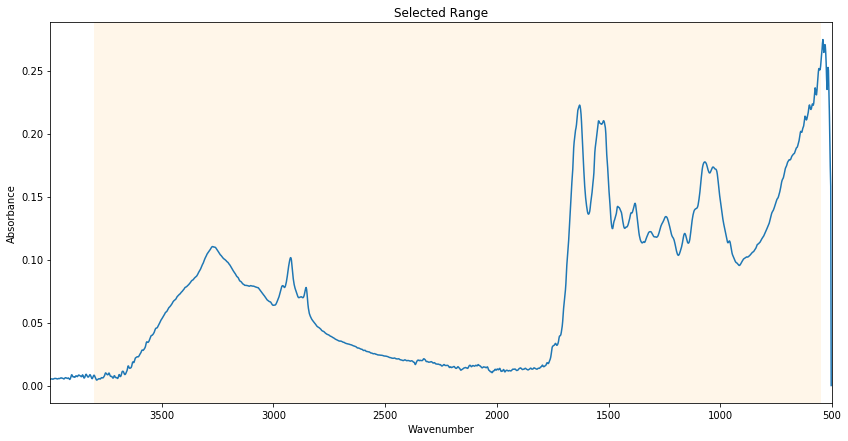

In [12]:
# We select a random spectrum:
n = np.random.randint(0,len(matrix)-1)
while not matrix[n]:
    n = np.random.randint(0,len(matrix)-1)

# we prepare the data
a = matrix[n][6][0]
b = matrix[n][6][1]
c = matrix[n][6][2]
xd = [a - x/c * (a-b) for x in range(c)]
yd = matrix[n][7]

# we draw the plot
plt.figure(figsize=(14,7))
plt.plot(xd,yd)
plt.xlim(a, b)

# and the selected wavenumbers
if len(wns) == 2 and einselechta == False:
    plt.axvspan(wns[0], wns[1], facecolor='papayawhip', alpha=0.5)
else:
    for i in wns:
        plt.axvline(x=i, c='black', lw=1)    
        
# labels
plt.xlabel('Wavenumber')
plt.ylabel('Absorbance')
if len(wns) == 2 and einselechta == False:
    plt.title('Selected Range')
else:
    plt.title('Selected Wavenumbers')

plt.show()

## Choose your own matrix

Now it is the time to export the data. Since *Loco mosquito* can deal with a lot of data, here is an algorithm to select only the spectra that we want for each variable. If you want to select all the characteristics of a variable, write ``"all"``

In [13]:
sel_species = "all"
sel_ages = "all"
sel_status = "all"
sel_country = "all"
sel_rear = "all"#"VF"#["TF", "TL"]

And now, the following algorithm will extract from the spectra the desired intensities and the desired characteristics:

In [14]:
# We start the timer
a = time.time()
# We define the variable that will contain the final data
fida = []
csc = 0
ssel = 0
# If we have selected a range of wavenumbers, now it is time to change it into discrete wavenumbers
if len(wns) == 2 and einselechta == False:
    resolution = 2
    if matrix[0][6][0] < wns[0]:
        wns[0] = int(matrix[0][6][0])
    if matrix[0][6][1] > wns[-1]:
        wns[-1] = int(matrix[0][6][-1])+1
    wns = list(range(wns[0],wns[1],-resolution))
    
# And start the algorithm to extract the info
for i in matrix:
    # If that item exist
    if i:
        # If the item has the selected characteristics
        if sel_species == "all" or sel_species == "All" or sel_species == "ALL":
            sel_species = list_species
        if sel_ages == "all" or sel_ages == "All" or sel_ages == "ALL":
            sel_ages = list_ages
        if sel_status == "all" or sel_status == "All" or sel_status == "ALL":
            sel_status = list_status
        if sel_country == "all" or sel_country == "All" or sel_country == "ALL":
            sel_country = list_country
        if sel_rear == "all" or sel_rear == "All" or sel_rear == "ALL":
            sel_rear = list_rear
        if i[0] in sel_species and i[1] in sel_ages and i[2] in sel_status and i[3] in sel_country and i[4] in sel_rear:
            # we count the number of spectra that are removed because are too short for the range of wavenumbers selected
            if i[6][0] >= wns[0] and i[6][1] <= wns[-1]:
                pos = []
                for j in wns:
                    pos.append(int(round((((i[6][2] - 1) / (i[6][1] - i[6][0])) * (j - i[6][0])) + 1)) - 1)
                lint = []
                for k in pos:
                    lint.append(i[7][k])
                fida.append([i[0], i[1], i[2], i[3], i[4], str(int(i[5]))] + lint)
                ssel += 1
            else:
                csc += 1
fida = sorted(fida)
fida.insert(0,["Species", "Age", "Status", "Country", "RearCnd", "StoTime"] + wns)
if (csc) == 0:
    pass
elif (csc) == 1:
    print("1 spectrum has been discarded because was shorter than the selected wavenumbers")
else:
    print(str(csc) + " spectra have been discarded because were shorter than the selected wavenumbers")  
b = time.time()
print("This last process has lasted " + str(round(b-a,3)) + " s. The new matrix cotains " + str(ssel) + " spectra.")

This last process has lasted 89.059 s. The new matrix cotains 34661 spectra.


## Exporting the matrix

Now we export the matrix with the info in the same folder where the data were collected

In [ ]:
with open(spectra_path + "mosquitos_country.dat", 'w') as file:
    sc = csv.writer(file, delimiter='\t')
    for i in fida:
            sc.writerow(i)